In [17]:
import pickle

import librosa
import librosa.feature

import numpy as np
import sns as sns
import tensorflow as tf

import tensorflow_decision_forests as tfdf

from scipy import stats

In [7]:
def get_mfcc(y, sr):
    return np.array(librosa.feature.mfcc(y=y, sr=sr))


def get_mel_spectrogram(y, sr):
    return np.array(librosa.feature.melspectrogram(y=y, sr=sr))


def get_chroma_stft(y, sr):
    return np.array(librosa.feature.chroma_stft(y=y, sr=sr))


def get_chroma_cens(y, sr):
    return np.array(librosa.feature.chroma_cens(y=y, sr=sr))

def get_tonnetz(y, sr):
    return np.array(librosa.feature.tonnetz(y=y, sr=sr))


def get_zero_crossing_rate(y):
    return librosa.feature.zero_crossing_rate(y)


def get_spectral_bandwidth(y, sr):
    return librosa.feature.spectral_bandwidth(y=y, sr=sr)


def get_spectral_centroid(y, sr):
    return librosa.feature.spectral_centroid(y=y, sr=sr)


def get_spectral_rolloff(y, sr):
    return librosa.feature.spectral_rolloff(y=y, sr=sr)


def get_spectral_contrast(y, sr):
    return librosa.feature.spectral_contrast(y=y, sr=sr)


def get_poly_features(y, sr):
    return librosa.feature.poly_features(y=y, sr=sr)


def get_feature_stats(values):
    return {
        'mean': np.mean(values, axis=1),
        'std': np.std(values, axis=1),
        'skew': stats.skew(values, axis=1),
        'kurtosis': stats.kurtosis(values, axis=1),
        'median': np.median(values, axis=1),
        'min': np.min(values, axis=1),
        'max': np.max(values, axis=1),
    }


def concatenate_feature_stats(feature_stats):
    return np.concatenate((
        feature_stats['mean'],
        feature_stats['std'],
        feature_stats['skew'],
        feature_stats['kurtosis'],
        feature_stats['median'],
        feature_stats['min'],
        feature_stats['max']
    ))


def get_feature(y, sr):
    mfcc = get_mfcc(y, sr)
    feature_stats = get_feature_stats(mfcc)
    mfcc_feature = concatenate_feature_stats(feature_stats)

    mel_spectrogram = get_mel_spectrogram(y, sr)
    feature_stats = get_feature_stats(mel_spectrogram)
    mel_spectrogram_feature = concatenate_feature_stats(feature_stats)

    chroma_stft = get_chroma_stft(y, sr)
    feature_stats = get_feature_stats(chroma_stft)
    chroma_stft_feature = concatenate_feature_stats(feature_stats)

    chroma_cens = get_chroma_cens(y, sr)
    feature_stats = get_feature_stats(chroma_cens)
    chroma_cens_feature = concatenate_feature_stats(feature_stats)

    tonnetz = get_tonnetz(y, sr)
    feature_stats = get_feature_stats(tonnetz)
    tonnetz_feature = concatenate_feature_stats(feature_stats)

    zero_crossing_rate = get_zero_crossing_rate(y)
    feature_stats = get_feature_stats(zero_crossing_rate)
    zero_crossing_rate_feature = concatenate_feature_stats(feature_stats)

    spectral_bandwidth = get_spectral_bandwidth(y, sr)
    feature_stats = get_feature_stats(spectral_bandwidth)
    spectral_bandwidth_feature = concatenate_feature_stats(feature_stats)

    spectral_rolloff = get_spectral_rolloff(y, sr)
    feature_stats = get_feature_stats(spectral_rolloff)
    spectral_rolloff_feature = concatenate_feature_stats(feature_stats)

    spectral_centroid = get_spectral_centroid(y, sr)
    feature_stats = get_feature_stats(spectral_centroid)
    spectral_centroid_feature = concatenate_feature_stats(feature_stats)

    spectral_contrast = get_spectral_contrast(y, sr)
    feature_stats = get_feature_stats(spectral_contrast)
    spectral_contrast_feature = concatenate_feature_stats(feature_stats)

    poly_features = get_poly_features(y, sr)
    feature_stats = get_feature_stats(poly_features)
    poly_features_feature = concatenate_feature_stats(feature_stats)

    return np.concatenate((
        chroma_stft_feature,
        chroma_cens_feature,
        mel_spectrogram_feature,
        mfcc_feature,
        tonnetz_feature,
        zero_crossing_rate_feature,
        spectral_bandwidth_feature,
        spectral_centroid_feature,
        spectral_rolloff_feature,
        spectral_contrast_feature,
        poly_features_feature,
    ))


In [62]:
def generate_features():
    with open('../pickles/processed_data.pkl', 'rb') as f:
        data = pickle.load(f)
    xs = []
    ys = []
    filenames = []
    for label, y, sr, filename in data:
        features = get_feature(y, sr)
        xs.append(features)
        ys.append(label)
        filenames.append(filename)
    features = np.array(xs)
    labels = np.array(ys)

    with open('track_features.pkl', 'wb') as f:
        pickle.dump({"features": features, "labels": labels, "filenames": filenames}, f)


In [63]:
generate_features()

In [19]:
model = tf.keras.models.load_model('../saved_models/random_forest_3')
model.summary()


[INFO 23-05-28 08:30:18.2337 BST kernel.cc:1242] Loading model from path ../saved_models/random_forest_3/assets/ with prefix 4d3d74283d62459d


Model: "random_forest_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________


[INFO 23-05-28 08:30:18.5394 BST decision_forest.cc:660] Model loaded with 300 root(s), 56508 node(s), and 1325 input feature(s).
[INFO 23-05-28 08:30:18.5398 BST kernel.cc:1074] Use fast generic engine


In [20]:
def load_data():
    with open('./track_features.pkl', 'rb') as f:
        data = pickle.load(f)

    return data


In [21]:
data = load_data()
data


{'features': array([[ 4.15284574e-01,  1.88751370e-01,  2.38558665e-01, ...,
          1.90051907e-01, -2.50370455e-05,  5.26561333e+00],
        [ 3.05086821e-01,  4.11871135e-01,  3.02782238e-01, ...,
          6.05055444e-01, -7.51342267e-05,  8.62808626e+00],
        [ 4.24001545e-01,  3.10383350e-01,  3.85087997e-01, ...,
          9.83716555e-01, -1.22716268e-04,  1.23256043e+01],
        ...,
        [ 3.03198457e-01,  3.16565067e-01,  5.12915492e-01, ...,
          2.05824098e+00, -1.98326703e-04,  1.11196818e+01],
        [ 5.12703180e-01,  3.51487219e-01,  3.12366277e-01, ...,
          2.40252496e+00, -1.45308054e-04,  9.23447969e+00],
        [ 3.60429823e-01,  4.77471173e-01,  4.03136909e-01, ...,
          4.81110826e+00, -5.73429526e-04,  1.31817255e+01]]),
 'labels': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [22]:
embeddings = model.predict(tf.constant(data["features"]))
embeddings


32/32 [==============================] - 4s 4ms/step


array([[0.33666644, 0.11333329, 0.15999992, ..., 0.01666667, 0.07666666,
        0.07333333],
       [0.6733328 , 0.00333333, 0.11666662, ..., 0.00666667, 0.07999999,
        0.06666667],
       [0.68666613, 0.00333333, 0.03666667, ..., 0.00333333, 0.01333333,
        0.05333334],
       ...,
       [0.06666667, 0.00333333, 0.02333334, ..., 0.        , 0.00333333,
        0.55666625],
       [0.03333334, 0.00333333, 0.15333326, ..., 0.04333334, 0.02666667,
        0.54666626],
       [0.08666665, 0.00333333, 0.03666667, ..., 0.01      , 0.01      ,
        0.6166662 ]], dtype=float32)

## Features Nearest Neighbours

### PCA, LDA, NCA

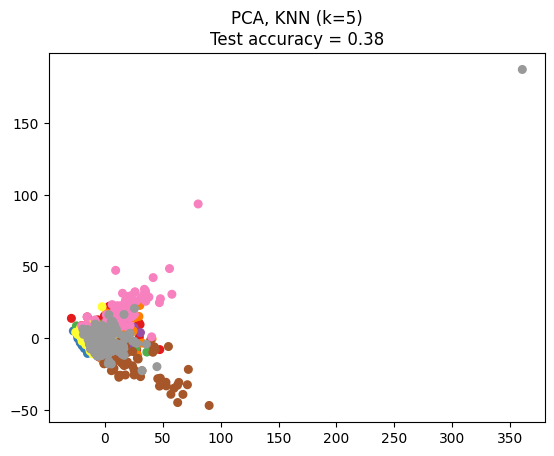

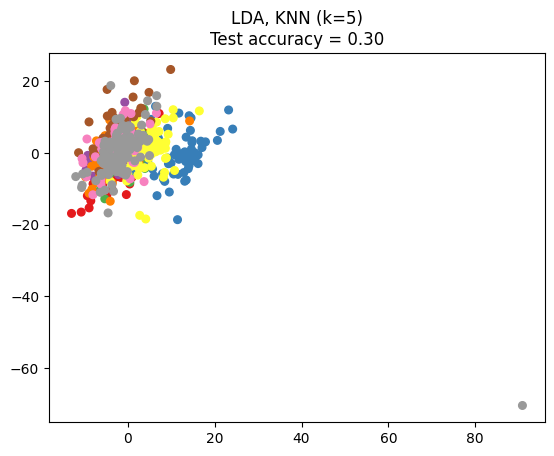

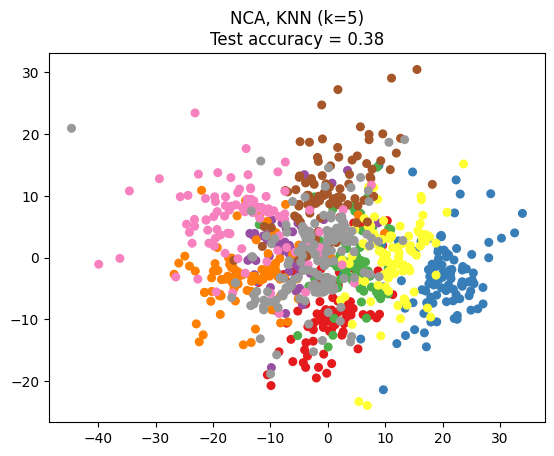

In [46]:
"""
Dimensionality Reduction with Neighborhood Components Analysis
https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html#sphx-glr-auto-examples-neighbors-plot-nca-dim-reduction-py
"""
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

n_neighbors = 5
random_state = 0

# Load Digits dataset
X, y = (data["features"], data["labels"])
# Split into train/test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=random_state
)

dim = len(X[0])
n_classes = len(np.unique(y))

# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=random_state))

# Reduce dimension to 2 with LinearDiscriminantAnalysis
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=2, random_state=random_state),
)

# Use a nearest neighbor classifier to evaluate the methods
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Make a list of the methods to be compared
dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca)]

# plt.figure()
for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()

    # Fit the method's model
    model.fit(X_train, y_train)

    # Fit a nearest neighbor classifier on the embedded training set
    knn.fit(model.transform(X_train), y_train)

    # Compute the nearest neighbor accuracy on the embedded test set
    acc_knn = knn.score(model.transform(X_test), y_test)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(X)

    # Plot the projected points and show the evaluation score
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap="Set1")
    plt.title(
        "{}, KNN (k={})\nTest accuracy = {:.2f}".format(name, n_neighbors, acc_knn)
    )

plt.show()

### TSNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 999 samples in 0.001s...
[t-SNE] Computed neighbors for 999 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 999 / 999
[t-SNE] Mean sigma: 1196.039482
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.842400
[t-SNE] KL divergence after 1000 iterations: 0.947043


[Text(0.5, 1.0, 'Iris data T-SNE projection')]

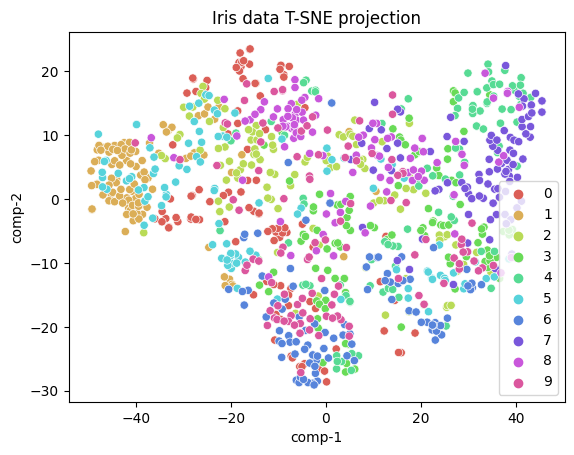

In [48]:
import pandas as pd
from sklearn.manifold import TSNE

x = data["features"]
y = data["labels"]

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x)

df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="Iris data T-SNE projection")

In [23]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=25)
knn.fit(data["features"])
# select indices of k nearest neighbours
neighbours = knn.kneighbors([data["features"][250]], return_distance = False)
neighbours

array([[250, 257, 118, 227, 878, 528, 251, 294, 263, 189, 321, 862, 565,
        808, 509, 919, 297, 298, 285, 855, 924, 549, 534, 848, 335]])

In [24]:
for index in neighbours[0]:
    print(data["filenames"][index])

country.00036.wav
country.00032.wav
classical.00057.wav
country.00015.wav
reggae.00077.wav
jazz.00089.wav
country.00022.wav
country.00047.wav
country.00025.wav
classical.00062.wav
disco.00083.wav
reggae.00002.wav
jazz.00090.wav
reggae.00083.wav
jazz.00000.wav
rock.00099.wav
country.00046.wav
country.00091.wav
country.00044.wav
reggae.00001.wav
rock.00098.wav
jazz.00096.wav
jazz.00098.wav
reggae.00033.wav
disco.00056.wav


## Prediction Nearest Neighbours

### PCA, LDA, NCA

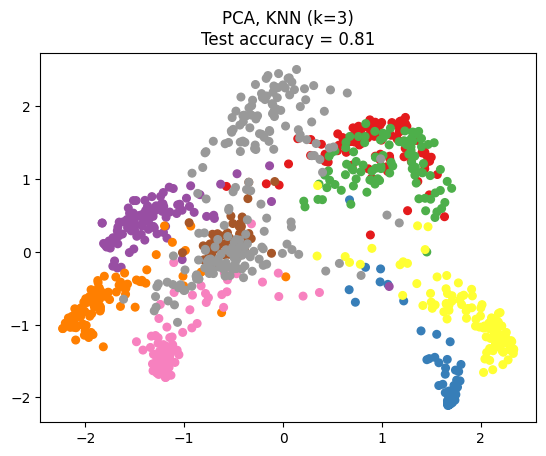

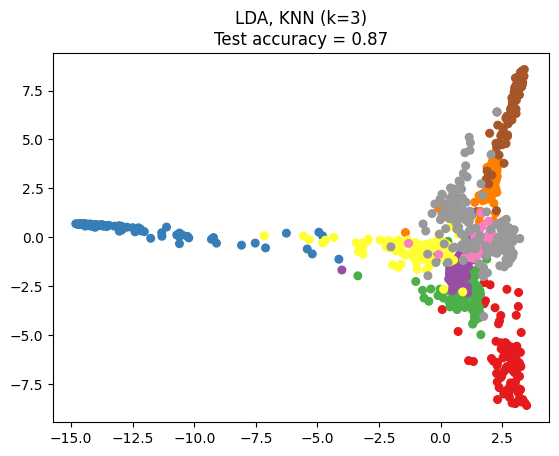

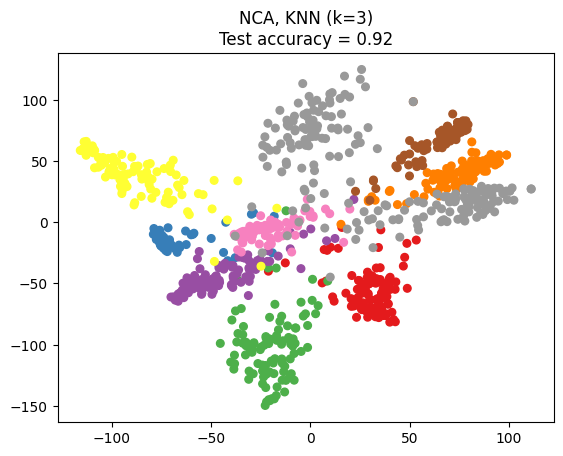

In [42]:
"""
Dimensionality Reduction with Neighborhood Components Analysis
https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html#sphx-glr-auto-examples-neighbors-plot-nca-dim-reduction-py
"""
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

n_neighbors = 3
random_state = 0

# Load Digits dataset
X, y = (embeddings, data["labels"])
# Split into train/test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=random_state
)

dim = len(X[0])
n_classes = len(np.unique(y))

# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=random_state))

# Reduce dimension to 2 with LinearDiscriminantAnalysis
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=2, random_state=random_state),
)

# Use a nearest neighbor classifier to evaluate the methods
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Make a list of the methods to be compared
dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca)]

# plt.figure()
for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()

    # Fit the method's model
    model.fit(X_train, y_train)

    # Fit a nearest neighbor classifier on the embedded training set
    knn.fit(model.transform(X_train), y_train)

    # Compute the nearest neighbor accuracy on the embedded test set
    acc_knn = knn.score(model.transform(X_test), y_test)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(X)

    # Plot the projected points and show the evaluation score
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap="Set1")
    plt.title(
        "{}, KNN (k={})\nTest accuracy = {:.2f}".format(name, n_neighbors, acc_knn)
    )

plt.show()


### TSNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 999 samples in 0.001s...
[t-SNE] Computed neighbors for 999 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 999 / 999
[t-SNE] Mean sigma: 0.056437
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.059647
[t-SNE] KL divergence after 1000 iterations: 0.285173


[Text(0.5, 1.0, 'Iris data T-SNE projection')]

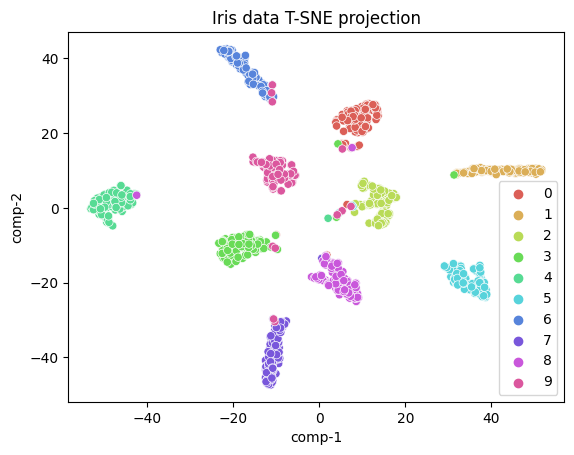

In [49]:
import pandas as pd
from sklearn.manifold import TSNE

x = embeddings
y = data["labels"]

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x)

df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="Iris data T-SNE projection")

In [25]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=25)
knn.fit(embeddings)
# select indices of k nearest neighbours
neighbours = knn.kneighbors([embeddings[250]], return_distance = False)
neighbours

array([[250, 230, 222, 527, 229, 259, 125, 261, 294, 233, 197, 296, 919,
        127, 262, 234, 274, 252, 216, 585, 306, 958, 224, 213, 206]])

In [26]:
for index in neighbours[0]:
    print(data["filenames"][index])


country.00036.wav
country.00017.wav
country.00067.wav
jazz.00076.wav
country.00029.wav
country.00030.wav
classical.00056.wav
country.00019.wav
country.00047.wav
country.00016.wav
classical.00048.wav
country.00052.wav
rock.00099.wav
classical.00054.wav
country.00031.wav
country.00012.wav
country.00069.wav
country.00023.wav
country.00064.wav
jazz.00008.wav
disco.00047.wav
rock.00045.wav
country.00028.wav
country.00065.wav
country.00048.wav
